In [1]:
import nltk
import re
import os
import IPython
from nltk.draw import TreeWidget
from nltk.draw.util import CanvasFrame
from nltk.tag import SequentialBackoffTagger
from nltk import load_parser
from nltk import word_tokenize, sent_tokenize

In [2]:
operators = {
    'plus': '+',
    'add': '+',
    'sum': '+',
    '+': '+',
    'difference': '-',
    'minus': '-',
    '-': '-',
    'product': '*',
    'multiply': '*',
    '*': '*',
    'divide': '/',
    'division': '/',
    '/': '/'
}

operative_adjectives = {
    "added": "+",
    "divided": "/",
    "multiplied": "*",
    "substracted": "-"
}

In [3]:
def jupyter_draw_nltk_tree(tree):
    cf = CanvasFrame()
    tc = TreeWidget(cf.canvas(), tree)
    tc['node_font'] = 'arial 13 bold'
    tc['leaf_font'] = 'arial 14'
    tc['node_color'] = '#005990'
    tc['leaf_color'] = '#3F8F57'
    tc['line_color'] = '#175252'
    cf.add_widget(tc, 10, 10)
    cf.print_to_file('tmp_tree_output.ps')
    cf.destroy()
    os.system('convert tmp_tree_output.ps tmp_tree_output.png')
    IPython.core.display.display(IPython.core.display.Image(filename='tmp_tree_output.png'))
    os.system('rm tmp_tree_output.ps tmp_tree_output.png')

In [4]:
class OperatorTagger(SequentialBackoffTagger):
    
    def __init__(self, *args, **kwargs):
        SequentialBackoffTagger.__init__(self, *args, **kwargs)
        self.operator_set = operators.keys()
        self.operative_adjectives = ['added', 'multiplied', 'divided', 'substracted']
        
    def choose_tag(self, tokens, index, history):
        tag = None
        if tokens[index] in self.operator_set:
            tag = 'OPERATOR'
        elif tokens[index] in self.operative_adjectives:
            tag = 'OPER_ADJ'
        else:
            tag = nltk.pos_tag([tokens[index]])[0][1]
        return tag

In [5]:
def ie_process(sentence):
    tokenized_words = re.findall(r"(\b\w*[\.]?\w+\b|[\(\)\+\*\-\/])", sentence)
    print(tokenized_words)
    operator_tagger = OperatorTagger()
    tagged_words = operator_tagger.tag(tokenized_words)
    return tagged_words

In [6]:
def chunk(tagged_sentence):
    grammar = r"""
    ME: {<CD><OPERATOR><CD>}
    """
    cp = nltk.RegexpParser(grammar)
    tree = cp.parse(tagged_sentence)
    jupyter_draw_nltk_tree(tree)
    return tree

In [7]:
def transform_chunk(expression, temp, chunk=None):
    if expression.endswith("("):
        temp.append(")")
    expression += ''.join(temp)
    if chunk:
        expression = "(" + expression + ")"
        expression += operative_adjectives[chunk[0]]
        expression += "("
    return expression
    
def process_chunk(chunked_sentence):
    expression = ""
    temp = []
    for chunk in chunked_sentence:
        if isinstance(chunk, nltk.tree.Tree) and chunk.label() == 'ME':
            temp.append(process_chunk(chunk))
        elif chunk[1] == "CD":
            temp.append(chunk[0])
        elif chunk[1] == "OPERATOR":
            temp.append(operators[chunk[0]])
        elif chunk[1] == "OPER_ADJ":
            print("OPER_ADJ")
            expression = transform_chunk(expression, temp, chunk)
            temp = []
        print("----------------------------------------------------")
        print(expression)
        print(temp)
    if temp: expression = transform_chunk(expression, temp)
    return expression

In [8]:
ie_process('What is 2 added by 2?')

['What', 'is', '2', 'added', 'by', '2']


[('What', 'WP'),
 ('is', 'VBZ'),
 ('2', 'CD'),
 ('added', 'OPER_ADJ'),
 ('by', 'IN'),
 ('2', 'CD')]

['What', 'is', '2', '+', '3', '+', '5', '+', '77', 'multiplied', 'by', '5', '+', '43', 'added', 'by', '7']


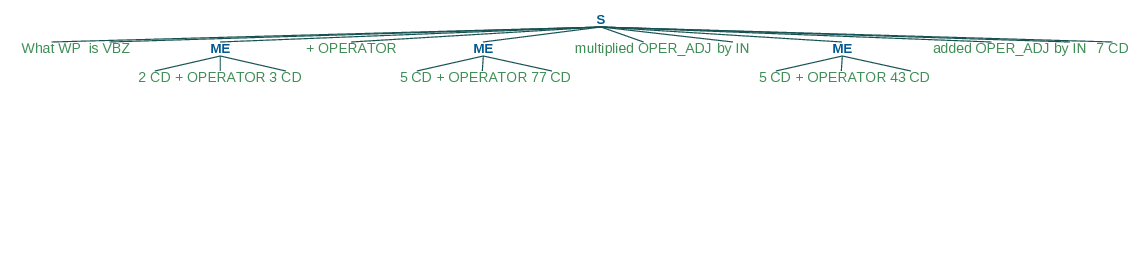

----------------------------------------------------

[]
----------------------------------------------------

[]
----------------------------------------------------

['2']
----------------------------------------------------

['2', '+']
----------------------------------------------------

['2', '+', '3']
----------------------------------------------------

['2+3']
----------------------------------------------------

['2+3', '+']
----------------------------------------------------

['5']
----------------------------------------------------

['5', '+']
----------------------------------------------------

['5', '+', '77']
----------------------------------------------------

['2+3', '+', '5+77']
OPER_ADJ
----------------------------------------------------
(2+3+5+77)*(
[]
----------------------------------------------------
(2+3+5+77)*(
[]
----------------------------------------------------

['5']
----------------------------------------------------

['5', '+']
-------------------

'((2+3+5+77)*(5+43))+(7)'

In [9]:
process_chunk(chunk(ie_process('What is 2+3+5+77 multiplied by 5+43 added by 7?')))

In [10]:
func_map = {
    "+": lambda x, y: x + y,
    "-": lambda x, y: x - y,
    "*": lambda x, y: x * y,
    "/": lambda x, y: x / y ,
    "^": lambda x, y: x ^ y
}

In [11]:
def infix2postfix(expression):
    """Converts an Infix expression to a Postfix expression
    
    expression: input an infix expression
    
    Returns: an postfix expression
    """
    print("Printing expression")
    print(expression)
    stack = []
    stack.append('e');
    number_str=''
    operators = ['^', '*', '/', '+', '-']
    operator_precedence = {
        "^": 4,
        "*": 3,
        "/": 3,
        "+": 2,
        "-": 2,
        "(": 0,
        ")": 0,
        'e': 0
    }
    for token in expression:
        if not token.isdigit() and number_str:
            yield number_str
            number_str = ""
        
        if token in operators:
            while True:
                if operator_precedence[token] > operator_precedence[stack[-1]]:
                    stack.append(token)
                    break
                else:
                    yield stack.pop()
                    
        elif token.isdigit():
            number_str += token
                    
        elif token == "(":
            stack.append(token)
            
        elif token == ")":
            while True:
                ch = stack.pop()
                if ch == "(":
                    break
                else:
                    yield ch
    if number_str:
        yield number_str
        
    for s in reversed(stack[1:]):
        yield s

In [12]:
def postfix_calculate(iterator):
    """Performs calculation over postfix expression.
    
    iterator: inputs an postfix iterator
    
    Returns: a calculated value of the postfix expression
    """
    stack = []
    for ch in iterator:
        try:
            print(ch)
            stack.append(float(ch))
        except ValueError:
            func = func_map[ch]
            y = stack.pop()
            x = stack.pop()
            stack.append(func(x, y))

    return stack[0]

['What', 'is', '2', '+', '3', '+', '5', '+', '77', 'divided', 'by']


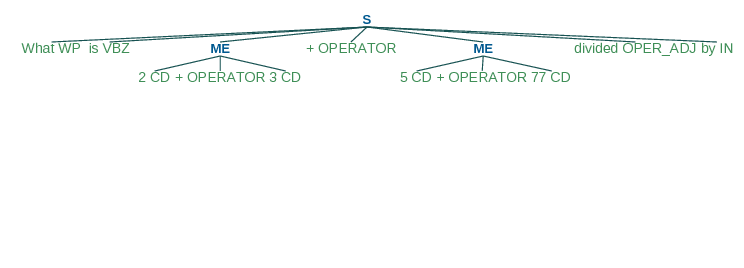

----------------------------------------------------

[]
----------------------------------------------------

[]
----------------------------------------------------

['2']
----------------------------------------------------

['2', '+']
----------------------------------------------------

['2', '+', '3']
----------------------------------------------------

['2+3']
----------------------------------------------------

['2+3', '+']
----------------------------------------------------

['5']
----------------------------------------------------

['5', '+']
----------------------------------------------------

['5', '+', '77']
----------------------------------------------------

['2+3', '+', '5+77']
OPER_ADJ
----------------------------------------------------
(2+3+5+77)/(
[]
----------------------------------------------------
(2+3+5+77)/(
[]
Printing expression
(2+3+5+77)/(
2
3
+
5
+
77
+
(
Ooops that didnt work


In [13]:
try:
    print(postfix_calculate(infix2postfix(process_chunk(chunk(ie_process('What is 2+3+5+77 divided by ?'))))))
except ZeroDivisionError:
    print("Arrgh, I cant divide by zero")
except:
    print("Ooops that didnt work")

In [19]:
import re, math
from corpus import read_corpus
from util import MathProcessor
from collections import Counter
import numpy as np

def get_cosine_distance(statement, other_statement):
    tokenized_statement = word_tokenize(statement.lower())
    tokenized_other_statement = word_tokenize(other_statement.lower())
    vector1 = Counter(tokenized_statement)
    vector2 = Counter(tokenized_other_statement)
    intersection = set(vector1) & set(vector2)
    numerator = sum([vector1[word] * vector2[word] for word in intersection])
    squared_sum_of_vector1 = sum([vector1[word] ** 2 for word in vector1.keys()])
    squared_sum_of_vector2 = sum([vector2[word] ** 2 for word in vector2.keys()])
    root_of_squared_sum_of_vector1 = math.sqrt(squared_sum_of_vector1)
    root_of_squared_sum_of_vector2 = math.sqrt(squared_sum_of_vector2)
    denominator = root_of_squared_sum_of_vector1 * root_of_squared_sum_of_vector2
    if not denominator:
        return 0
    else:
        return float(numerator) / denominator
    
    
def synset_distance(statement, other_statement):
    """
    Calculate the similarity of two statements.
    This is based on the total maximum synset similarity between each word in each sentence.
    This algorithm uses the `wordnet`_ functionality of `NLTK`_ to determine the similarity
    of two statements based on the path similarity between each token of each statement.
    This is essentially an evaluation of the closeness of synonyms.
    :return: The percent of similarity between the closest synset distance.
    :rtype: float
    .. _wordnet: http://www.nltk.org/howto/wordnet.html
    .. _NLTK: http://www.nltk.org/
    """
    from nltk.corpus import wordnet
    from nltk.corpus import stopwords
    from nltk import word_tokenize
    import itertools

    tokens1 = list(set(word_tokenize(statement.lower())) - set(stopwords.words('english')))
    tokens2 = list(set(word_tokenize(other_statement.lower())) - set(stopwords.words('english')))

    # The maximum possible similarity is an exact match
    # Because path_similarity returns a value between 0 and 1,
    # max_possible_similarity is the number of words in the longer
    # of the two input statements.
    max_possible_similarity = max(
        len(statement.split()),
        len(other_statement.split())
    )

    max_similarity = 0.0

    # Get the highest matching value for each possible combination of words
    for combination in itertools.product(*[tokens1, tokens2]):

        synset1 = wordnet.synsets(combination[0])
        synset2 = wordnet.synsets(combination[1])

        if synset1 and synset2:

            # Get the highest similarity for each combination of synsets
            for synset in itertools.product(*[synset1, synset2]):
                similarity = synset[0].path_similarity(synset[1])

                if similarity and (similarity > max_similarity):
                    max_similarity = similarity

    if max_possible_similarity == 0:
        return 0

    return max_similarity / max_possible_similarity

def classify_intent(sentence):
    tagged_words = nltk.pos_tag(word_tokenize(sentence))
    num_tagged_cd = len([tag for word, tag in tagged_words if tag == 'CD'])
    intent = None
    if num_tagged_cd:
        intent = 'compute'
    else:
        intent = 'converse'
    return intent

def answer(question):
    """Responds to the question asked
    question: inputs a nlp statement
    
    Returns: a calculated value in response to the input statement
    """
    sentences = sent_tokenize(question)
    print(sentences)
    results = []
    mp = MathProcessor()
    for sentence in sentences:
        sentence = mp.transform_text(sentence)
        intent = classify_intent(sentence)
        print("intent",intent)
        if intent == 'compute':
            rows = read_corpus('mathqa.corpus', extension="csv")
            cosine_scores = np.array([get_cosine_distance(sentence, data[0]) for data in rows])
            matched_response = rows[np.argmax(cosine_scores)]
            print(matched_response)
            try:
                tagged_sentence = ie_process(sentence)
                chunked_sentence = chunk(tagged_sentence)
                processed_chunk = process_chunk(chunked_sentence)
                if len(set(['>', '<', '>=', '<=', '==', '!=']) & set(list(processed_chunk))) == 0:
                    eval_result = str(postfix_calculate(infix2postfix(processed_chunk)))
                else:
                    eval_result = str(eval(processed_chunk))
                print(matched_response)
                results.append(matched_response[1].format(eval_result))
            except:
                results.append(matched_response[2])
        else:
            rows = read_corpus('conversations.corpus', extension="csv")
            cosine_scores = np.array([get_cosine_distance(sentence, data[0]) for data in rows])
            matched_response = rows[np.argmax(cosine_scores)]
            print(matched_response)
            results.append(matched_response[1])
    return results

['What do i get if I substract 3 from 2']
intent compute
['what is 24+55 divided by 2?', 'That computes to {0}', "Pheww didn't work. Can I do something else fo you."]
['What', 'do', 'i', 'get', 'if', 'I', 'substract', '3', 'from', '2']


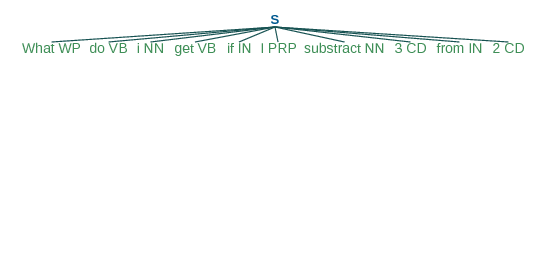

----------------------------------------------------

[]
----------------------------------------------------

[]
----------------------------------------------------

[]
----------------------------------------------------

[]
----------------------------------------------------

[]
----------------------------------------------------

[]
----------------------------------------------------

[]
----------------------------------------------------

['3']
----------------------------------------------------

['3']
----------------------------------------------------

['3', '2']
Printing expression
32
32
['what is 24+55 divided by 2?', 'That computes to {0}', "Pheww didn't work. Can I do something else fo you."]


['That computes to 32.0']

In [21]:
answer('What do i get if I substract 3 from 2')

In [ ]:
dictionary = {'one': 1}
if "one" in dictionary:
    print("Hi")

In [ ]:
if isinstance([1,2,3], list):
    print("Hello")